In [246]:
# from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace


In [247]:
L = 16                       
N = L * L                   
mass = 1                    

# densidade
rho = 0.6  
# dimensao linear da caixa
boxsize = np.sqrt(N / rho)  

temper = 1.05                

# Raio de corte Lennard-Jones
rcut = 1.1                  
rcut = rcut**2

# Raio para lista de verlet
rv = 1.1                    
rv = rv**2

# Parameters of the lennard-jones potential
depth = 0.1
part_size = 0.1


In [248]:
# Configure the system's initial conditions
def conf_ini(N, boxsize, temper):
  L = int(
    np.sqrt(N)
  )  # Define a dimensao linear da rede quadrada  (Atencao!!! A raiz quadrada de N é suposta inteira)

  x = np.zeros(N)
  y = np.zeros(N)

  vx = np.zeros(N)
  vy = np.zeros(N)

  cont = 0
  for i in range(L):
    for j in range(L):
      # distribui as partículas numa rede quadrada centrada
      x[cont] = (i + 0.5) - L / 2
      y[cont] = (j + 0.5) - L / 2

      # Escolhe a velocidade uniformemente num circulo unitario
      phi = np.random.uniform(0, 2 * np.pi)
      vx[cont] = np.cos(phi)
      vy[cont] = np.sin(phi)

      cont += 1

  # normaliza as posições para dentro da caixa
  x = x / L * boxsize
  y = y / L * boxsize

  # normaliza as velocidades de acordo com o teorema da equiparticao da energia
  prov = np.sqrt((2.0 - 2.0 / N) * temper)

  vx = vx * prov
  vy = vy * prov

  # Zera o momento total das partículas
  prov = np.sum(vx)
  vx = vx - prov / N
  prov = np.sum(vy)
  vy = vy - prov / N

  return SimpleNamespace(**{ "x": x, "y": y, "vx": vx, "vy": vy })

# Calculate the distance between particles i and j
def calc_dist(i, j, state):
  x = state.x
  y = state.y
  xij = x[i] - x[j]  # Distancia entre as partículas
  yij = y[i] - y[j]

  xij = xij - boxsize * np.rint(
    xij / boxsize
  )  # aplica condicoes de contorno periódicas
  yij = yij - boxsize * np.rint(yij / boxsize)

  r2 = xij**2 + yij**2

  return r2, xij, yij

# Create the verlet list
def verlet_list(state, rv, boxsize):  # Cria uma lista de Verlet para definir os vizinhos
  x = state.x
  y = state.y

  N = len(x)  # numero de particulas

  nviz = np.zeros(N, np.int64)  # declara os arrays
  viz = np.empty(0, np.int64)

  cont = 0  # contador do numero de vizinhos (indice do array viz)

  for i in range(N):  # loop sobre todas as partículas
    for j in range(i + 1, N):  # loop sobre todos os possiveis vizinhos

      r2, *_ = calc_dist(i, j, state)

      if r2 < rv:
        cont += 1
        nviz[i] = cont
        viz = np.append(viz, [j])

  return nviz, viz

# Calculate the force at a distance r
def lennard_jones_force(r, depth, part_size):
  return 48*depth*(part_size**(12)/r**(14) - part_size**(6)/r**(-8))

# Velocity-verlet position step
def position_step(rt, vt, at, dt):
  r_step = rt + dt*vt + dt**2*at/2

  if (r_step >= L/2):
    return -L/2 + r_step % L/2
  elif (r_step < -L/2):
    return L/2 - np.abs(r_step) % L/2
  else:
    return r_step

# Velocity-verlet velocity step
def velocity_step(vt, at, a_step, dt):
  return vt + dt*(at + a_step)/2


In [249]:
def time_step(state, t, dt):
  nviz, viz = verlet_list(state, rv, boxsize)

  state.ax = np.zeros(N)
  state.ay = np.zeros(N)

  for i in range(N):
    nviz_i = nviz[i]
    viz_i = viz[nviz[i - 1] : nviz_i]

    axi = state.ax[i]
    ayi = state.ay[i]

    for j in viz_i:
      r2, xij, yij = calc_dist(i, j, state)
      if (r2 < 1.77*part_size):
        raise Exception('Position threshold reached')

      apply_potential = r2 < rcut

      if (apply_potential):
        force = lennard_jones_force(np.sqrt(r2), depth, part_size)

        r_ang = np.arccos(xij**2/r2)

        axi += 0 if xij == 0 else (xij/np.abs(xij))*force*np.cos(r_ang)/mass
        ayi += 0 if yij == 0 else (yij/np.abs(yij))*force*np.sin(r_ang)/mass

      state.ax[j] -= axi
      state.ay[j] -= ayi

    state.x[i] = position_step(state.x[i], state.vx[i], state.ax[i], dt)
    state.y[i] = position_step(state.y[i], state.vy[i], state.ay[i], dt)

    state.vx[i] = velocity_step(state.vx[i], state.ax[i], axi, dt)
    state.vy[i] = velocity_step(state.vy[i], state.ay[i], ayi, dt)

    state.ax[i] += axi
    state.ay[i] += ayi


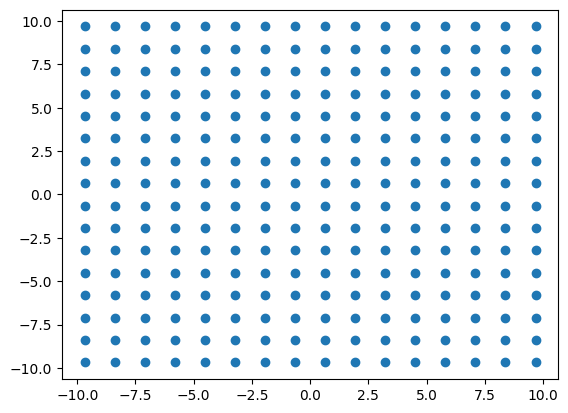

In [250]:
state = conf_ini(N, boxsize, temper)

In [251]:
i = 0
while(True):
  i+=1
  time_step(state, 0, 0.01)

Exception: Position threshold reached